In [310]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import scienceplots


plt.style.use([
    'science',
    'notebook',
    'grid',
    'retro'
])

In [311]:
mass = 4 # kg

k1 = 4 # N/m
k2 = 4 # N/m
k3 = 4 # N/m

c1 = .4 # Ns/m
c2 = .2 # Ns/m
c3 = .1 # Ns/m

M = sp.Matrix([
    [mass, 0, 0],
    [0, 2*mass, 0],
    [0, 0, .5*mass]
])

K = sp.Matrix([
    [k1+k2, -k2, 0],
    [-k2, k2+k3, -k3],
    [0, -k3, k3]
])

C = sp.Matrix([
    [c1+c2, -c2, 0],
    [-c2, c2+c3, -c3],
    [0, -c3, c3]
])

X0 = np.array([
    [1.0],
    [.0],
    [.0]
])

V0 = np.array([
    [.15],
    [.23],
    [.37]
])

N = 3

In [312]:
# Calculando M á menos meio
M_minus_half = sp.zeros(N, N)
M_half = sp.zeros(N, N)


for i in range(N):
    M_minus_half[i, i] = (1/sp.sqrt(M[i, i])).evalf()
    M_half[i, i] = (sp.sqrt(M[i, i])).evalf()


# Calculando Ktil
K_til = M_minus_half @ K @ M_minus_half

# Calculando Ctil
C_til = M_minus_half @ C @ M_minus_half

# Encontrando as frequências naturais e amortecidas
lmbd = sp.symbols('lambda')

expr_wn = (K_til - lmbd*sp.eye(N))

eig_wn = sp.solve(expr_wn.det(), lmbd)
wn = [sp.re(sp.sqrt(eig_wn[i])) for i in range(N)]

In [313]:
# Encontrando os auto-vetores normalizados no unitário
norm_syms = [sp.Symbol(f'norm_{i}') for i in range(N)]

X = sp.Matrix(norm_syms)

norm_eq = sp.Eq(
    (X.T@X)[0],
    1
)

P = np.zeros((N, N))
for i in range(N):
    sys_wn = expr_wn.subs(lmbd, eig_wn[i])
    sys = sys_wn @ X

    sol = sp.solve(
        [sys[j] for j in range(N-1)] + [norm_eq],
        norm_syms,
        dict=True
    )[0]

    v = np.array([
        sol[norm_syms[j]] for j in range(N)
    ])

    P[:, i] = v

# Matriz P

diag_  = P.T @ C_til @ P
zetas  = [diag_[i, i] / (2*wn[i]) for i in range(N)]

wds    = [wn[i] * sp.sqrt(1 - zetas[i]**2) for i in range(N)]

# matrix spectral de P
S = M_minus_half @ P
S_inv = S.inv()

In [314]:
wn

[0.420861431432847, 1.41421356237310, 1.68014155818261]

In [315]:
wds

[0.420803557854679, 1.41300998659678, 1.67929154699946]

In [316]:
sp.pprint(P)

 [[-0.32198228 -0.81649658 -0.47922932]
  [-0.83004954  0.          0.55768967]
 [-0.45535171  0.57735027 -0.67773261]]


In [317]:
sp.pprint(S)

⎡-0.160991139377137  -0.408248290463863  -0.23961466227129 ⎤
⎢                                                          ⎥
⎢-0.29346682872699           0           0.197173072291637 ⎥
⎢                                                          ⎥
⎣-0.321982278754275  0.408248290463863   -0.479229324542581⎦


In [318]:
# condições iniciais inversas modais
r_0 = S_inv @ X0
r_dot_0 = S_inv @ V0

sp.pprint(r_0)
print(' ')
sp.pprint(r_dot_0)

⎡-0.643964557508549⎤
⎢                  ⎥
⎢-1.63299316185545 ⎥
⎢                  ⎥
⎣-0.958458649085161⎦
 
⎡-0.874840534762108⎤
⎢                  ⎥
⎢0.0571547606649399⎥
⎢                  ⎥
⎣-0.13560004450767 ⎦


In [319]:
# Calculando as soluções modais desacopladas
t = sp.symbols('t')

r = []

forced_response_forces = sp.Matrix([
    [.0],
    [.0],
    [.0]
])

B = sp.Matrix([
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0]
])

F = P.T @ M_minus_half @ B @ forced_response_forces
wf = 0

for i in range(N):
    w = wn[i]
    wd = wds[i]
    zeta = zetas[i]
    
    r_zero = r_0[i]
    rdot_zero = r_dot_0[i]

    Ai = sp.sqrt(
        ((r_zero * wd)**2 + (rdot_zero + zeta*w*r_zero)**2) / wd**2
    )

    phi_i = sp.atan(
        (r_zero*wd) / (rdot_zero + zeta*w*r_zero)
    )

    if rdot_zero == 0:
        phi_i = sp.pi/2
    
    expr_r = Ai*sp.exp(-zeta*w*t)*sp.sin(wd*t + phi_i)

    f0 = F[i]
    A0 = f0 / sp.sqrt( (w**2 - wf**2)**2 + (2*zeta*w*wf)**2 )
    theta = sp.atan( (2*zeta*w*wf) / (w**2 - wf**2) )
    
    if (w**2 - wf**2) == 0:
        theta = sp.pi/2

    expr_r += A0*sp.cos(wf*t - theta)
    
    r.append(
        expr_r
    )

R = sp.Matrix(r)
sp.pprint(F)

⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦


In [320]:
# Retornando ao dominio fisico
x_t = S @ sp.Matrix(r)
x_t.evalf()

x_t

Matrix([
[-0.666757555860179*exp(-0.0583333333333333*t)*sin(1.41300998659678*t + 1.55428461561864) - 0.231202580577956*exp(-0.0534373999036921*t)*sin(1.67929154699946*t + 1.45524384801581) - 0.352028214580755*exp(-0.00697926676297457*t)*sin(0.420803557854679*t + 0.298933101421396)],
[                                                                                           0.190250975053844*exp(-0.0534373999036921*t)*sin(1.67929154699946*t + 1.45524384801581) - 0.641703662419759*exp(-0.00697926676297457*t)*sin(0.420803557854679*t + 0.298933101421396)],
[ 0.666757555860179*exp(-0.0583333333333333*t)*sin(1.41300998659678*t + 1.55428461561864) - 0.462405161155914*exp(-0.0534373999036921*t)*sin(1.67929154699946*t + 1.45524384801581) - 0.704056429161513*exp(-0.00697926676297457*t)*sin(0.420803557854679*t + 0.298933101421396)]])

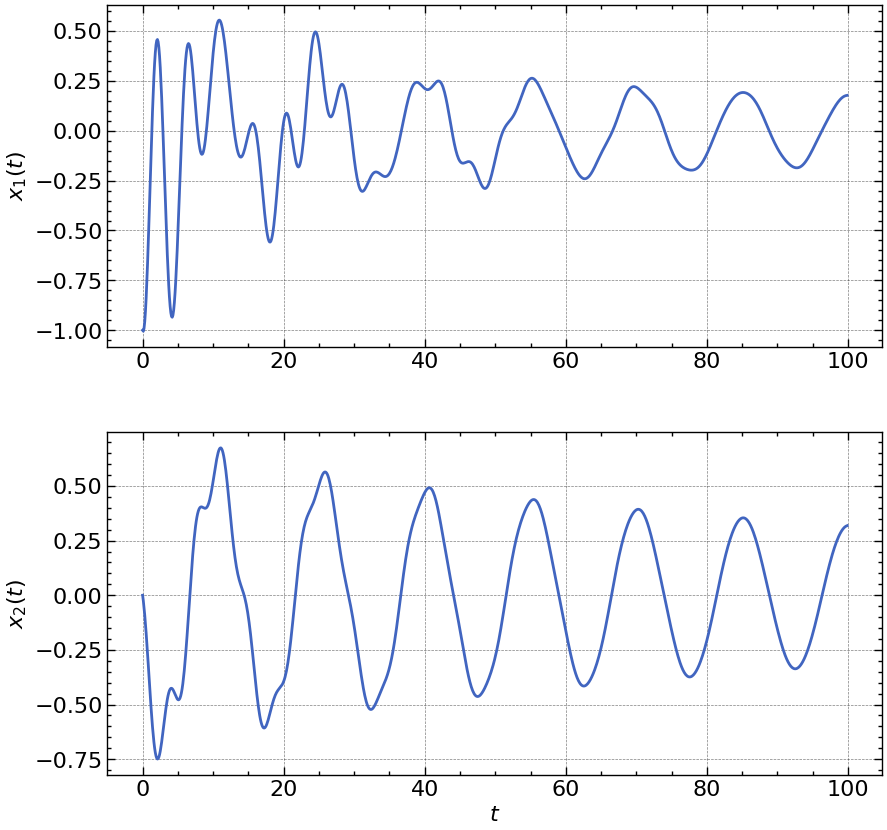

In [321]:
# Simulação

sampling_period = 1e-1
samples = 10000

time = np.arange(0, samples*sampling_period, sampling_period)

x1_t = sp.lambdify(t, x_t[0])
x2_t = sp.lambdify(t, x_t[1])

x1 = x1_t(time)
x2 = x2_t(time)

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
plt.subplots_adjust(hspace=0.25)

idx = int(100 / .1)

ax[0].plot(time[:idx], x1[:idx])
ax[0].set_ylabel('${x}_1(t)$')

ax[1].plot(time[:idx], x2[:idx])
ax[1].set_xlabel('$t$')
ax[1].set_ylabel('${x}_2(t)$')

plt.savefig('imagens/forced_response.png', dpi=300)

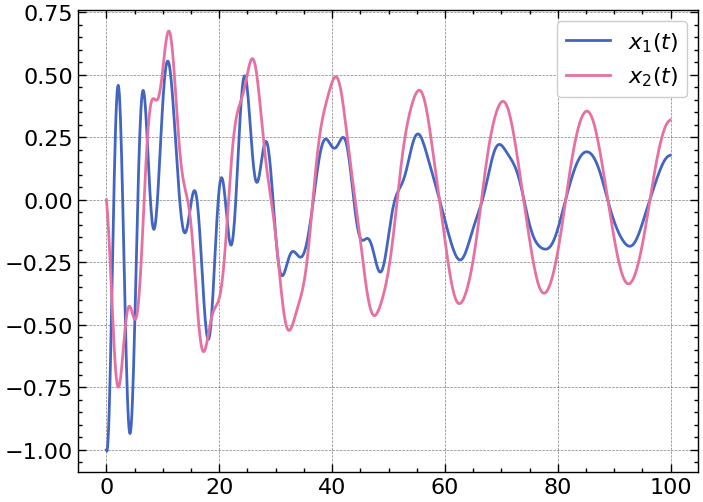

In [322]:
plt.figure()

plt.plot(time[:idx], x1[:idx], label='${x}_1(t)$')
plt.plot(time[:idx], x2[:idx], label='${x}_2(t)$')

plt.legend()

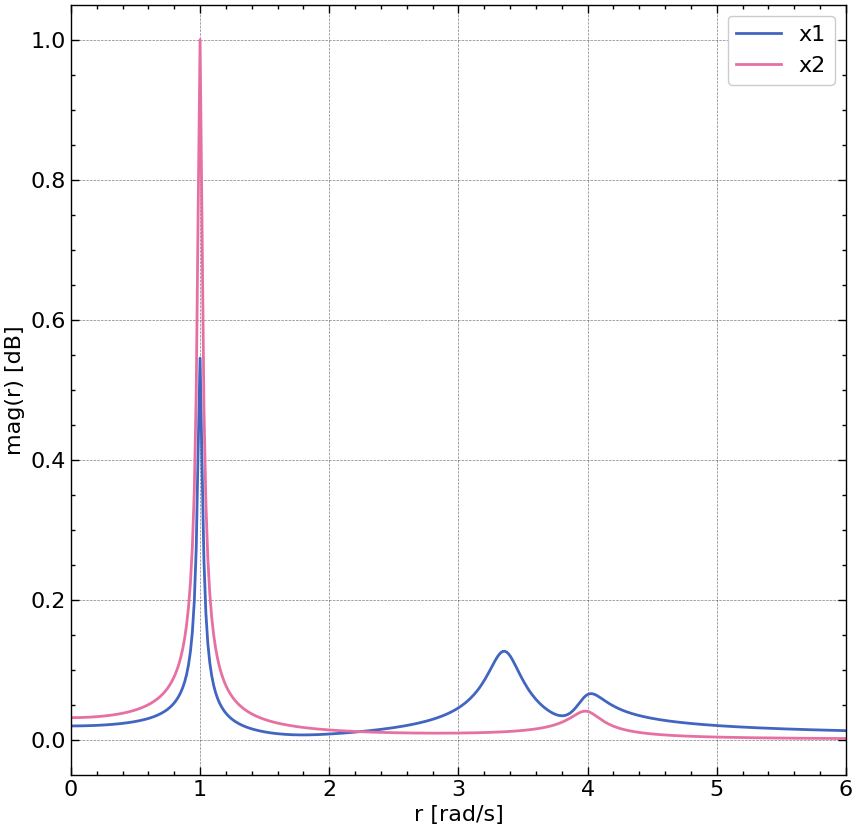

In [323]:
def fft(signal, sampling_time):
    fft = np.fft.fft(signal)
    N = signal.shape[0]

    f = np.fft.fftfreq(len(signal), sampling_time)

    K = N // 2

    freqs = f[:K]*2*np.pi
    amplitudes = np.abs(fft)[:K] * (1 / N)

    phase = np.rad2deg(np.angle(fft)[:K])

    return freqs, amplitudes, phase


fft_x1 = fft(x1, sampling_period)
fft_x2 = fft(x2, sampling_period)

maximum_amp = np.max([fft_x1[1], fft_x2[1]])
maximum_freq = np.max(
    [fft_x1[0][np.argmax(fft_x1[1])], fft_x2[0][np.argmax(fft_x2[1])]]
)

plt.figure(figsize=(10, 10))
plt.plot(
    fft_x1[0]/maximum_freq,
    fft_x1[1]/maximum_amp,
    label='x1'
)

plt.plot(
    fft_x2[0]/maximum_freq,
    fft_x2[1]/maximum_amp,
    label='x2'
)

plt.xlim(0, 6)
plt.xlabel('r [rad/s]')
plt.ylabel('mag(r) [dB]')
plt.legend()

plt.savefig('imagens/fft.png', dpi=300)